# Компьютер говорит "НЕТ"

Необходимо построить модель, которая позволяет оценить стоит ли выдавать кредит заемщику.

## Misc

Импорт нужных библиотек:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
def display_boxplot(data, column):
    bins = 100
    if column.nunique() < 100:
        bins = column.nunique()
    column.hist(bins=bins)
    plt.show()
    sns.boxplot(x='default', y=column, data=data)
    plt.show()

In [3]:
def outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    min_out = Q1 - 1.5 * IQR
    max_out = Q3 + 1.5 * IQR
    return (column < min_out).sum() + (column > max_out).sum(), min_out, max_out

## 1. Загрузка данных

In [4]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#DATA_DIR = '/kaggle/input/sf-scoring/'
#df_train = pd.read_csv(DATA_DIR +'/train.csv')
#df_test = pd.read_csv(DATA_DIR +'/test.csv')
#sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
df_train.shape

(73799, 19)

In [8]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [9]:
df_test.shape

(36349, 18)

In [10]:
sample_submission.head()

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [11]:
sample_submission.shape

(36349, 2)

## 2. Первоначальный анализ данных

### Overview

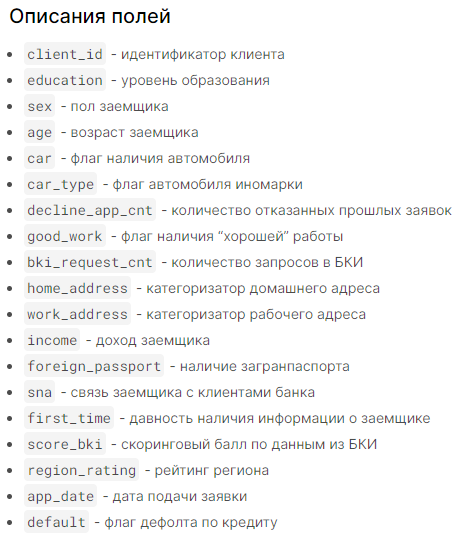

In [12]:
df_train.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

Здесь и ниже покажем несколько скринов из отчета panda profiling:

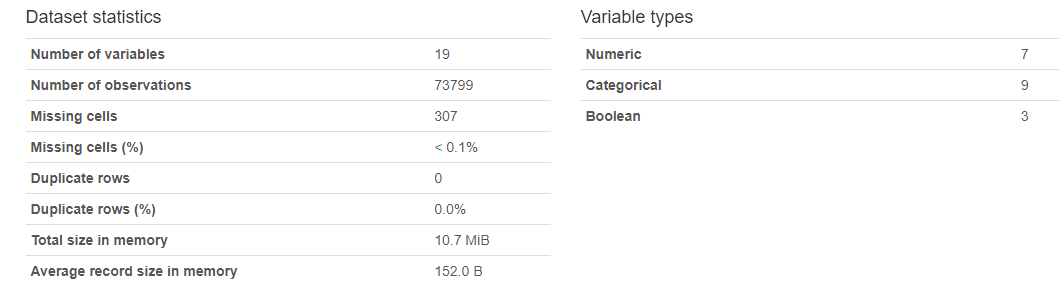

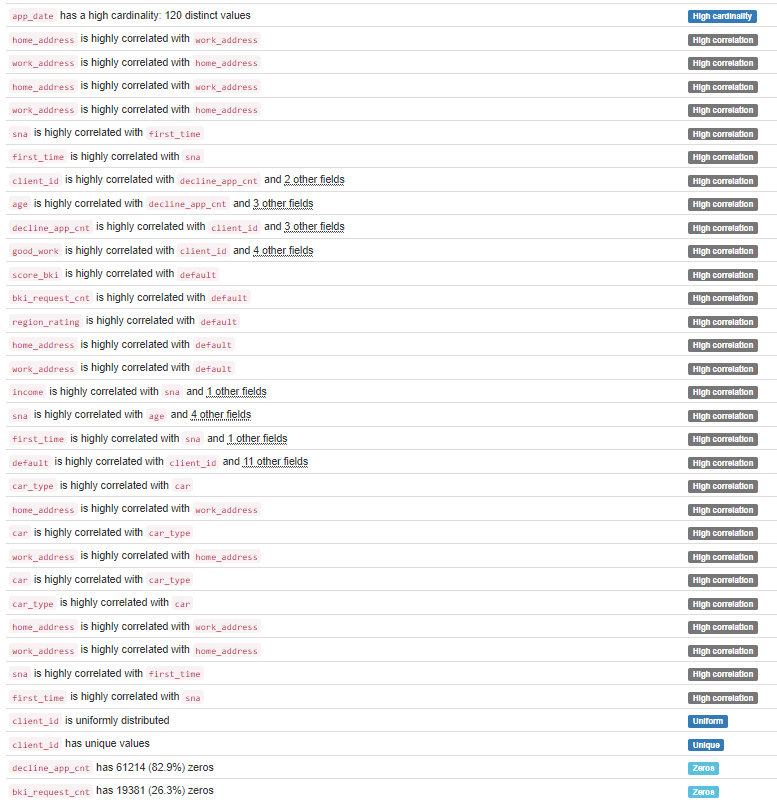

In [15]:
df_train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

Пропуски только в колонке **education**

### Признак 'client_id'

In [16]:
df_train.client_id.nunique()

73799

In [17]:
df_train.client_id.count()

73799

Подтверждаем теорию, что это уникальный идентификатор клиента и поэтому этот столбец лучше удалить.

### Признак 'app_date'

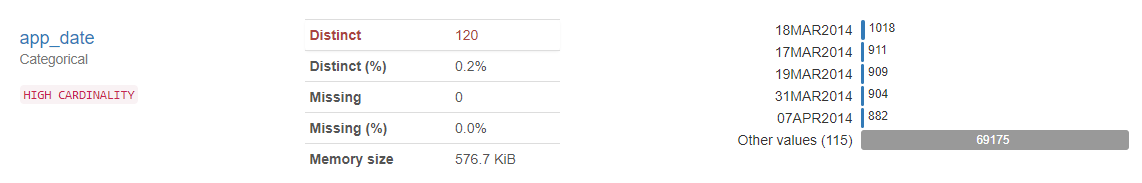

### Признак 'education'

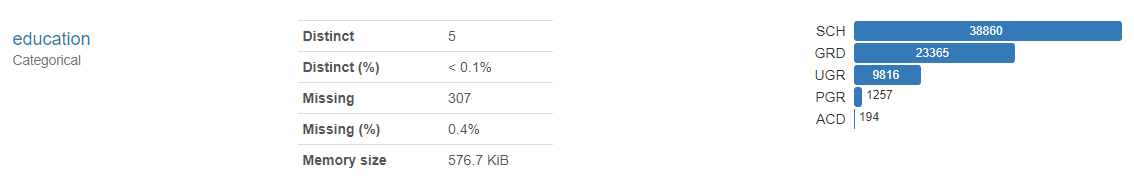

Категориальный признак - будем создавать dummy variables для него. При создании dummies учтем, что у признака есть пропуски.

<AxesSubplot:xlabel='education', ylabel='count'>

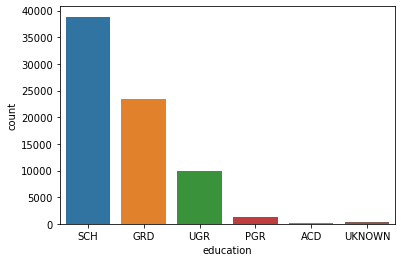

In [18]:
df = df_train.copy()
df['education'] = df['education'].fillna('UKNOWN')
sns.countplot(x=df['education'], data=df)

### Признак 'sex'

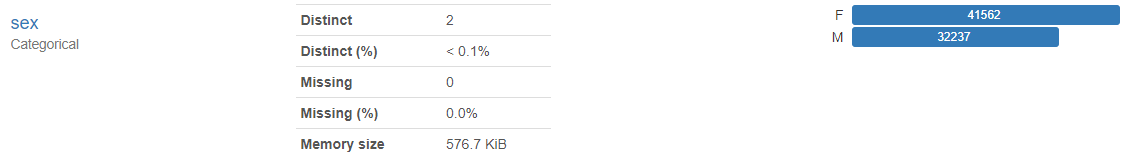

<AxesSubplot:xlabel='default', ylabel='count'>

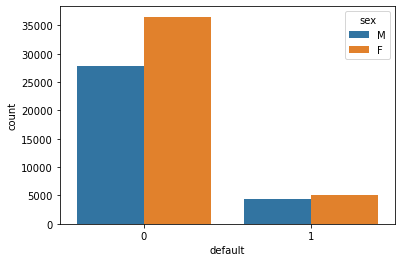

In [19]:
sns.countplot(x=df_train['default'], hue=df_train['sex'], data=df_train)

Бинарный признак. Пропусков нет.

### Признак 'age'

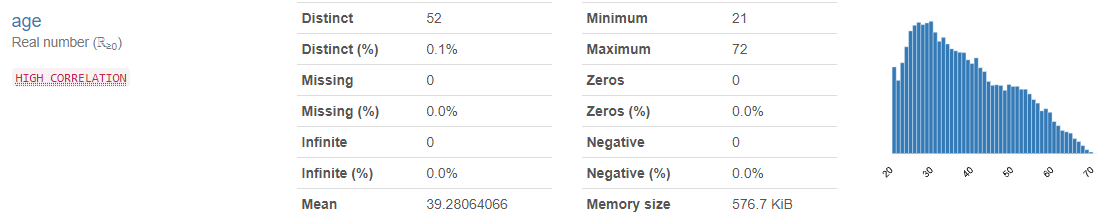

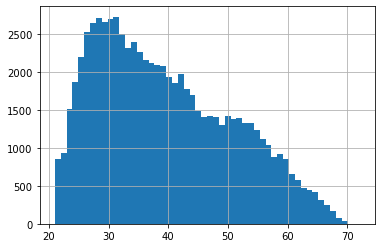

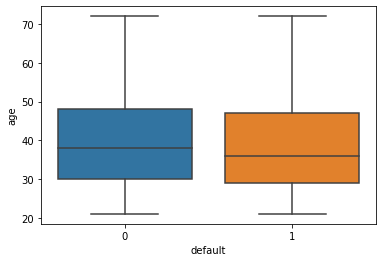

In [20]:
display_boxplot(df_train, df_train['age'])

Распределение близко к нормальному, но попробуем с логарифмом:

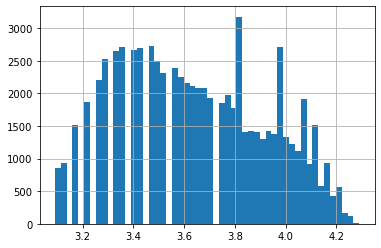

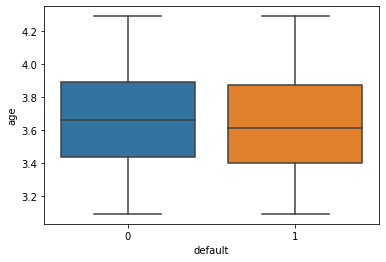

In [21]:
display_boxplot(df_train, np.log(df_train['age'] + 1))

Выглядит более "нормальным" сейчас...

### Признаки 'car' и 'car_type'

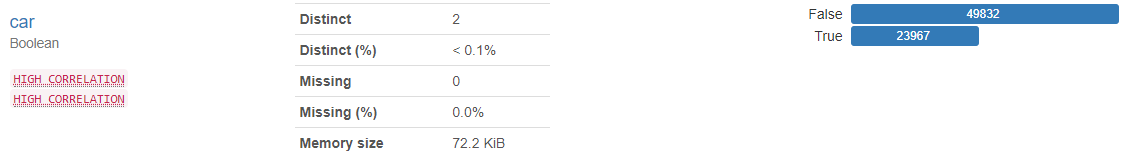

<AxesSubplot:xlabel='default', ylabel='count'>

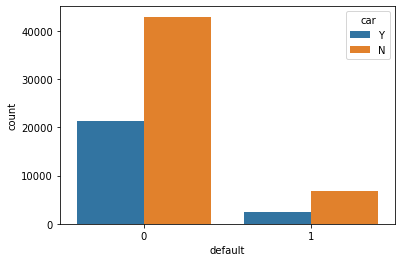

In [22]:
sns.countplot(x=df_train['default'], hue=df_train['car'], data=df_train)

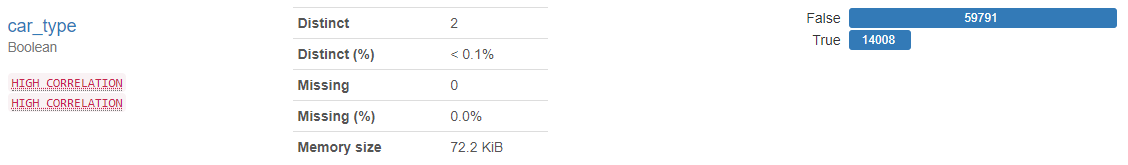

<AxesSubplot:xlabel='default', ylabel='count'>

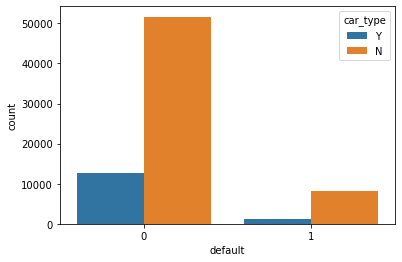

In [23]:
sns.countplot(x=df_train['default'], hue=df_train['car_type'], data=df_train)

Наличие машины, особенно иномарки, уменьшает вероятность дефолта. Попробуем из этих двух признаков собрать один (с тремя значениями)

### Признак 'decline_app_cnt'

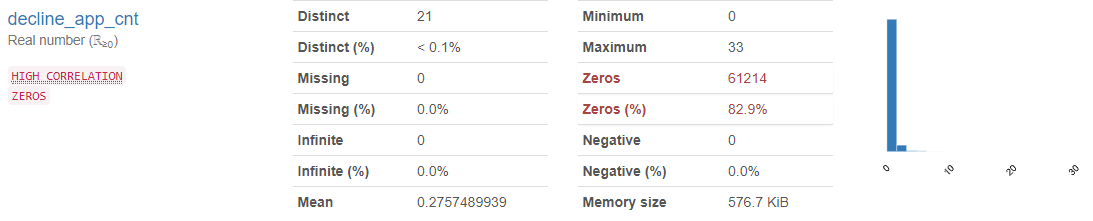

Признак числовое. Сильное смещение. Оценим количество выбросов:

In [24]:
outliers(df_train.decline_app_cnt)[0]

12585

Большое количество выбросов.

<AxesSubplot:xlabel='decline_app_cnt', ylabel='count'>

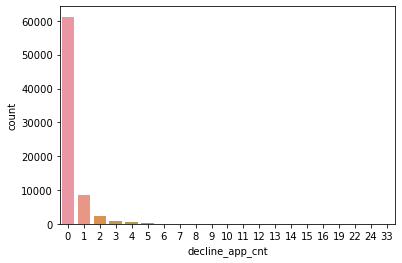

In [25]:
sns.countplot(x='decline_app_cnt', data=df_train)

Попробуем превратить признак в категориальный:
* 0
* 1
* 2
* 3 и больше

### Признак 'good_work'

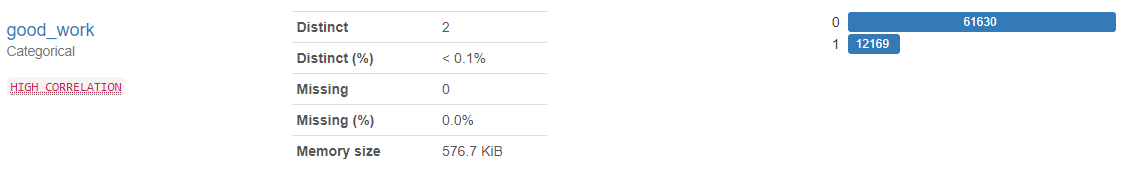

<AxesSubplot:xlabel='default', ylabel='count'>

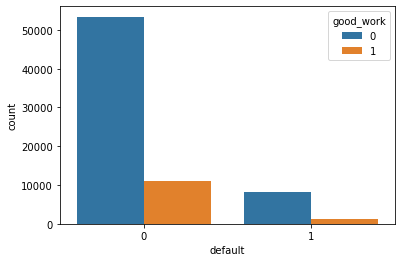

In [26]:
sns.countplot(x=df_train['default'], hue=df_train['good_work'], data=df_train)

Бинарный признак. Наличие хорошей работы понижает вероятность дефолта

### Признак 'score_bki'

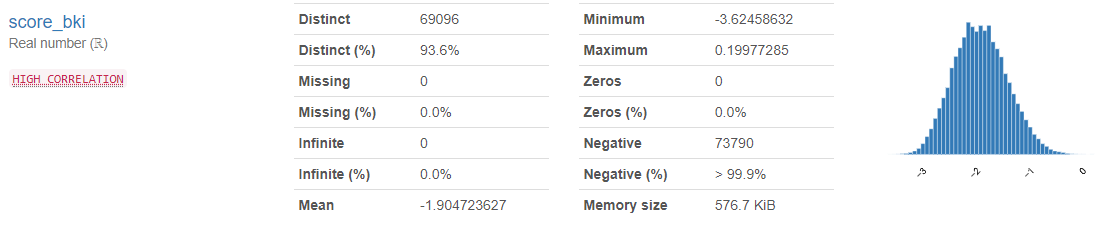

Признак числовое. Оценим количество выбросов:

In [27]:
outliers(df_train.score_bki)[0]

351

Выбросы будем зачищать ниже.

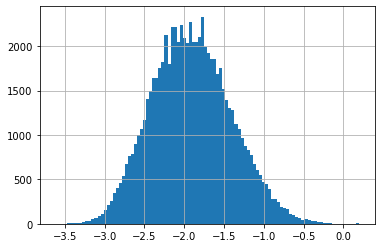

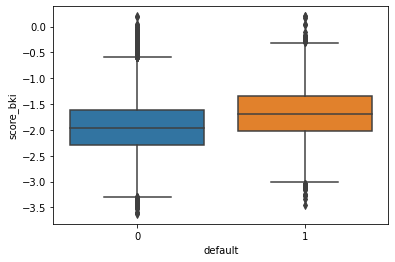

In [28]:
display_boxplot(df_train, df_train['score_bki'])

### Признак 'bki_request_cnt'

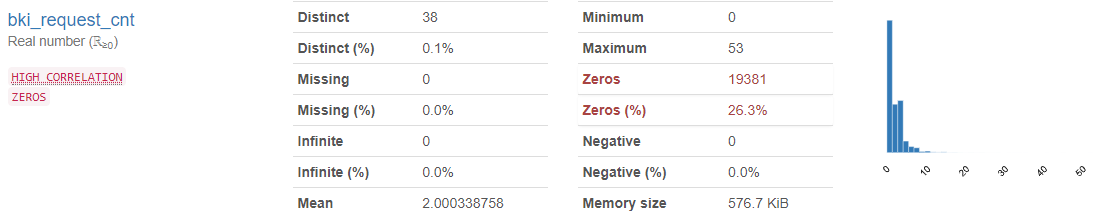

Количество выбросов:

In [29]:
outliers(df_train.bki_request_cnt)[0]

1755

Числовой признак. Сильное смещение вправо попробуем убрать логарифмированием:

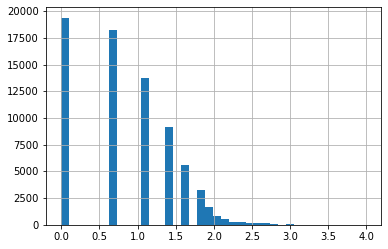

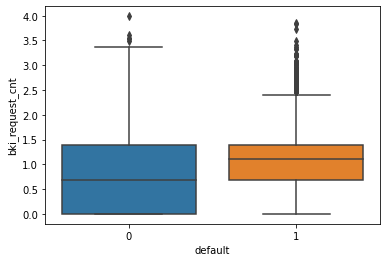

In [30]:
display_boxplot(df_train, np.log(df_train['bki_request_cnt'] + 1))

In [31]:
outliers(np.log(df_train.bki_request_cnt + 1))[0]

9

Количество выбросов уменьшилось и может быть проигнорировано.

### Признак 'region_rating'

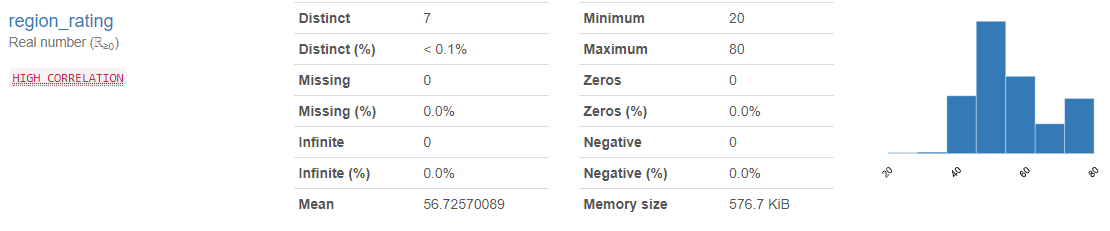

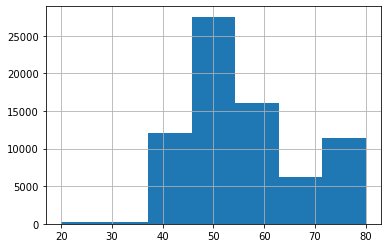

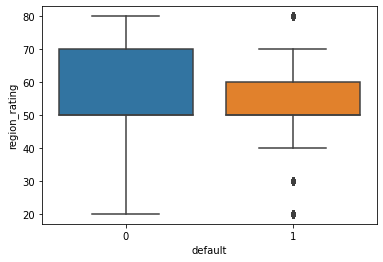

In [32]:
display_boxplot(df_train, df_train['region_rating'])

Категориальный тип

### Признак 'home_address'

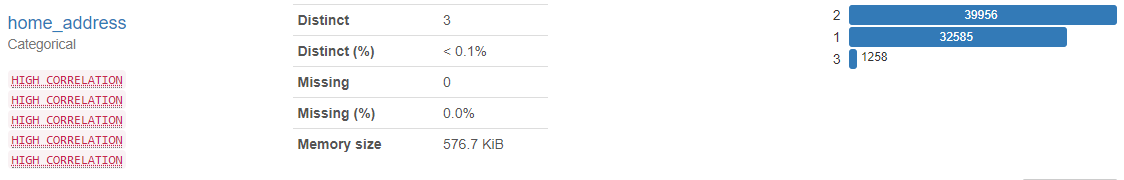

Категориальный тип

### Признак 'work_address'

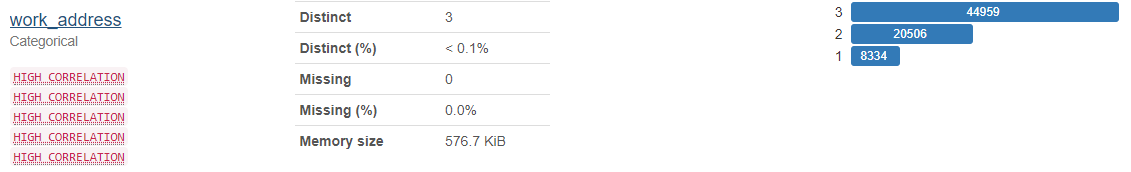

Категориальный тип

### Признак 'income'

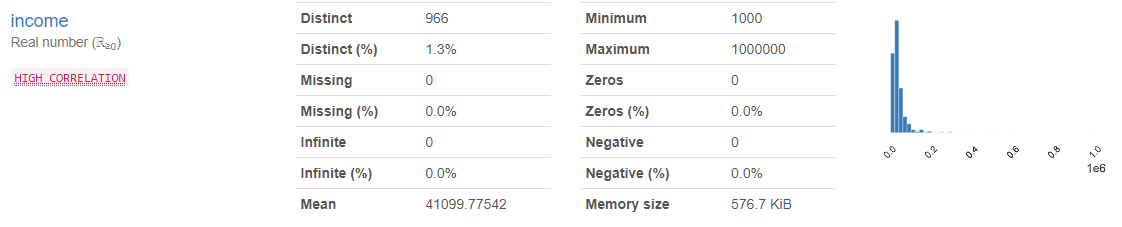

Числовой. Очень смещен. Выровняем логарифмированием:

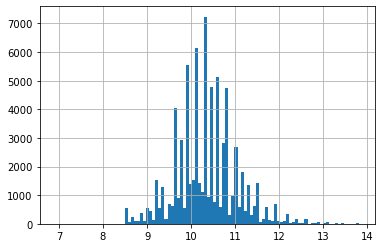

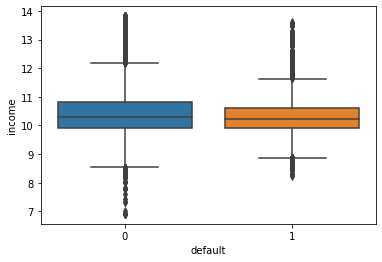

In [33]:
display_boxplot(df_train, np.log(df_train['income'] + 1))

Количество выбросов до логарифмирования:

In [34]:
outliers(df_train.income)[0]

4695

Количество выбросов после логарифмирования:

In [35]:
outliers(np.log(df_train.income + 1))[0]

1767

Все равно достаточно много выбросов - будем их зачищать

### Признак 'sna'

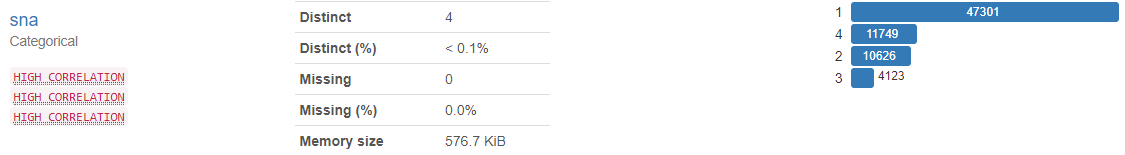

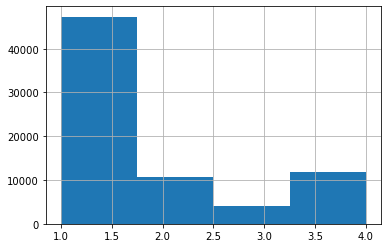

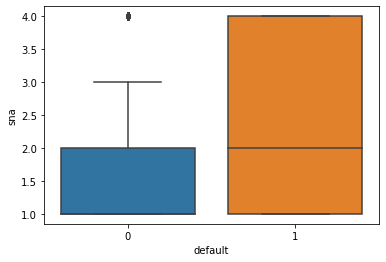

In [36]:
display_boxplot(df_train, df_train['sna'])

Категориальный тип

### Признак 'first_time'

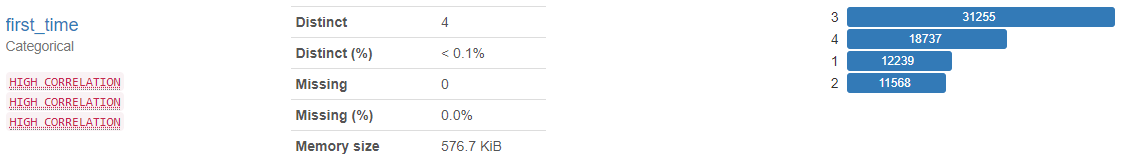

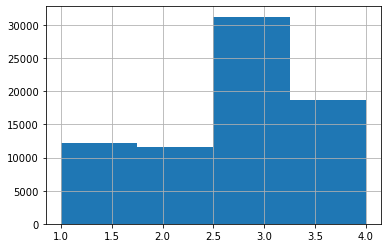

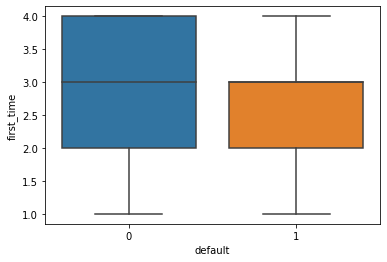

In [37]:
display_boxplot(df_train, df_train['first_time'])

Категориальный тип

### Признак 'foreign_passport'

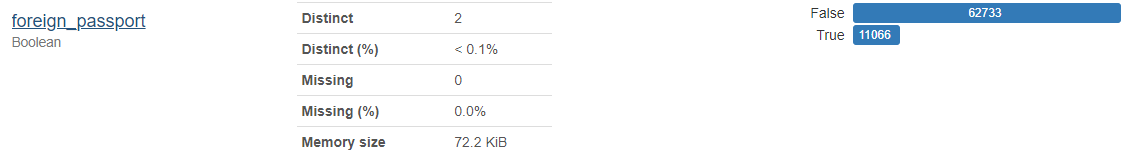

<AxesSubplot:xlabel='default', ylabel='count'>

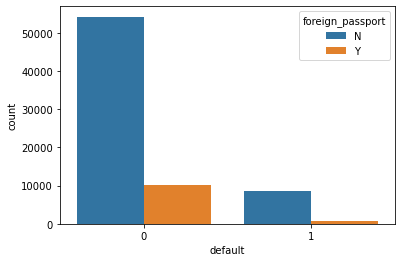

In [38]:
sns.countplot(x=df_train['default'],
              hue=df_train['foreign_passport'], data=df_train)

Бинарный признак

### Таргет 'default'

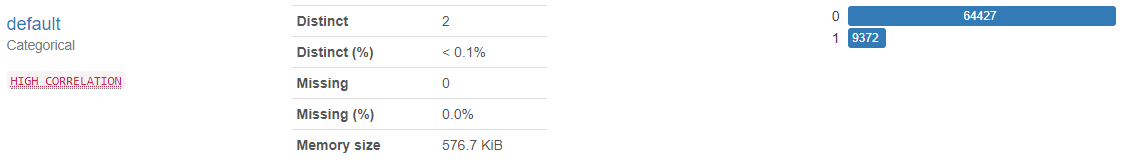

<AxesSubplot:>

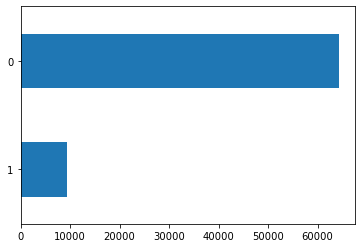

In [39]:
df_train['default'].value_counts(ascending=True).plot(kind='barh')

### Spearman's ρ

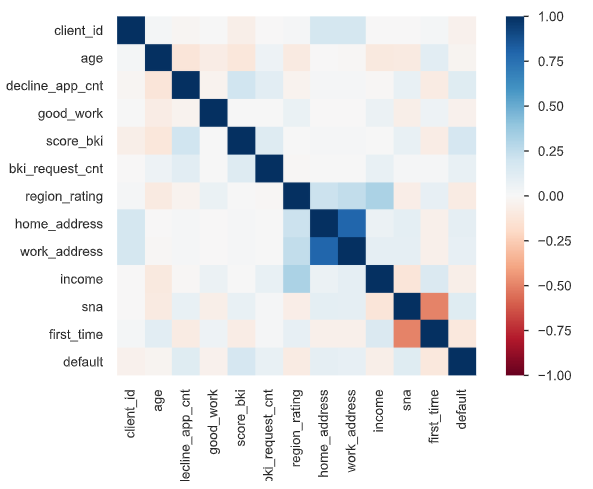

### Pearson's r

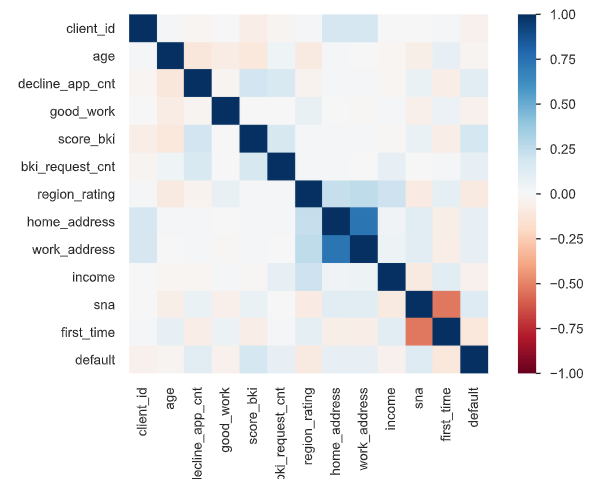

### Kendall's τ

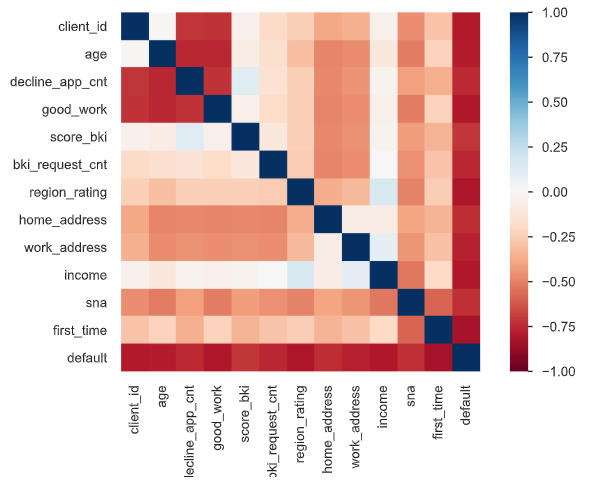

### Cramér's V (φc)

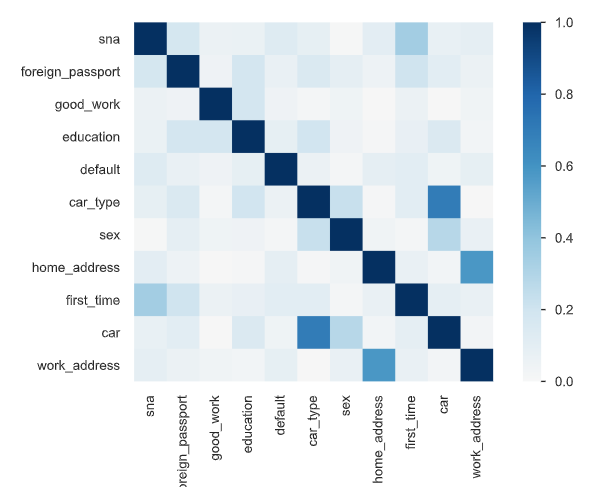

### Phik (φk)

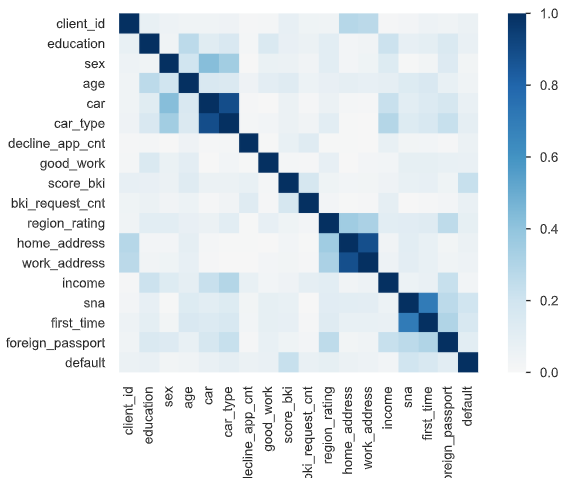

### Значимость числовых переменных

In [40]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address',
            'home_address', 'region_rating', 'sex', 'decline_app_cnt']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

<AxesSubplot:>

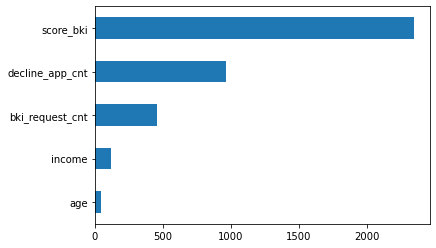

In [41]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

## 3. Предобработка данных

ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

In [42]:
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['default'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

Преобразуем **car** и **car_type** в один признак с тремя категориями. Назовём его просто **car**:

In [43]:
cat_order = {'N': 0, 'Y': 1}
data.car = data.car.replace(to_replace=cat_order) + \
    data.car_type.replace(to_replace=cat_order)
data.drop(columns=['car_type'], inplace=True)

bin_cols = ['sex', 'car', 'good_work', 'foreign_passport']

data.car.value_counts()

0    74290
2    21008
1    14850
Name: car, dtype: int64

Логарифмирурем **age** and **income**

In [44]:
data['age'] = np.log(data['age'] + 1)
data['income'] = np.log(data['income'] + 1)

Удалим признаки **client_id** и **app_date**:

In [45]:
data.drop(['client_id', 'app_date', ], axis=1, inplace=True)

Создадим dummies для **education**:

In [46]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

Превратим **decline_app_cnt** в категориальный признак:

In [47]:
data['decline_app_cnt'] = data['decline_app_cnt'].apply(
    lambda x: x if x < 3 else 3)
data['decline_app_cnt'].value_counts()

0    91471
1    12500
2     3622
3     2555
Name: decline_app_cnt, dtype: int64

Залейблим бинарные и категориальные признаки:

In [48]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])

columns = ['first_time', 'sna', 'work_address',
           'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

Пересчитаем пропорции классов в выборке после предварительной обработки данных:

In [49]:
p_good = data.default.value_counts()[0] / data.shape[0]
p_bad = data.default.value_counts()[1] / data.shape[0]
print(f'Надежные клиенты: {p_good:.3f}')
print(f'Плохие клиенты: {p_bad:>6.3f}')
print(f'Дисбаланс классов: {(p_good/p_bad):.1f}')

Надежные клиенты: 0.915
Плохие клиенты:  0.085
Дисбаланс классов: 10.8


К сожалению, у нас дисбаланс (> 1:10) классов!!!

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int32  
 1   age               110148 non-null  float64
 2   car               110148 non-null  int64  
 3   decline_app_cnt   110148 non-null  int64  
 4   good_work         110148 non-null  int64  
 5   score_bki         110148 non-null  float64
 6   bki_request_cnt   110148 non-null  int64  
 7   region_rating     110148 non-null  int64  
 8   home_address      110148 non-null  int64  
 9   work_address      110148 non-null  int64  
 10  income            110148 non-null  float64
 11  sna               110148 non-null  int64  
 12  first_time        110148 non-null  int64  
 13  foreign_passport  110148 non-null  int32  
 14  sample            110148 non-null  int64  
 15  default           110148 non-null  int64  
 16  education_ACD     11

In [51]:
data

,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,...,first_time,foreign_passport,sample,default,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_nan
0,1,3.401197,2,0,0,-2.271884,3,3,0,1,...,3,0,0,0,0,1,0,0,0,0
1,0,3.688879,0,3,0,-1.504999,2,3,0,1,...,2,0,0,0,0,0,0,1,0,0
2,1,3.931826,2,0,0,-1.691339,1,3,0,1,...,2,1,0,0,0,0,0,0,1,0
3,1,4.043051,0,0,0,-2.374182,1,2,0,1,...,2,0,0,0,0,0,0,1,0,0
4,0,3.663562,0,0,0,-2.487502,0,6,1,2,...,2,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,3.828641,0,0,0,-1.792064,3,3,0,1,...,3,0,1,0,0,1,0,0,0,0
110144,1,3.737670,2,0,0,-2.058029,1,3,1,1,...,3,0,1,0,0,0,0,1,0,0
110145,1,3.465736,0,0,0,-1.512635,4,6,1,2,...,1,0,1,0,0,0,0,1,0,0
110146,0,3.401197,0,0,1,-1.479334,3,3,0,2,...,2,0,1,1,0,0,0,1,0,0


## 4. Обучение

Выделим тестовую часть:

In [52]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

Построим модель с underfitting:

In [53]:
classes = train_data.default.value_counts(ascending=True)
minor = train_data[train_data.default == classes.index[0]]
other = train_data[train_data.default.isin(
    classes.index[1:])][:classes.iloc[0]]
train_data_balanced = pd.concat([other, minor])

y = train_data_balanced['default'].values  # наш таргет
X = train_data_balanced.drop(['default'], axis=1)

In [54]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [55]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14995, 20), (3749, 20), (14995,), (3749,))

In [56]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.linear_model import LogisticRegression
from sklearn import metrics  # инструменты для оценки точности модели

In [57]:
%%time
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
logreg = LogisticRegression()

iter_ = 1000
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

# model ваша модель логистической регрессии
gridsearch = GridSearchCV(logreg, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
logreg = gridsearch.best_estimator_

# печатаем параметры
best_parameters = logreg.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'none'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Wall time: 16.4 s


C:\Users\andrey\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.6643292         nan
 0.66437479        nan 0.66477363 0.66468501        nan 0.6639838
 0.66358445 0.66477363 0.66468501        nan 0.66407219 0.66367361
 0.6639692  0.66401459 0.66424036 0.66313274 0.66264517 0.6639692
 0.66401459 0.66424036 0.66313274 0.66268989 0.66450392 0.66472633
 0.66455985 0.66376171 0.66450392 0.66472633 0.66464897 0.66376171
 0.66405688 0.66423404 0.66433356 0.66308983 0.66405688 0.66423404
 0.66420135 0.66299981]
  warnings.warn(


In [58]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [59]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1887
           1       0.68      0.68      0.68      1862

    accuracy                           0.68      3749
   macro avg       0.68      0.68      0.68      3749
weighted avg       0.68      0.68      0.68      3749



Confusion matrix:

In [60]:
confusion_matrix(y_test, y_pred)

array([[1281,  606],
       [ 594, 1268]], dtype=int64)

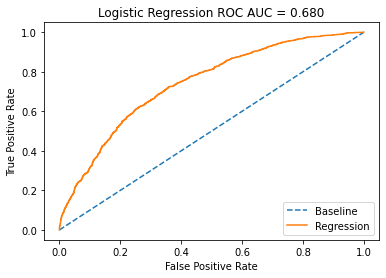

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [62]:
predict_submission = logreg.predict(test_data)

In [63]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [64]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.381083
std,31706.052195,0.485660
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [65]:
#!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"